# Plot the figure in paper

### Read all result data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns

save_bbox = Bbox([[0.7, 0.2], [9.2, 4.5]])

def read_csv(fnPattern):
    # find files with fileformat
    pattern = re.compile(fnPattern + '[0-9]+.csv')
    files = [f for f in os.listdir('results') if pattern.match(f)]
    dfs = []
    for f in files:
        tmp_df = pd.read_csv('results/' + f)
        tmp_df['step'] = tmp_df.index
        # if terminal_observation exists, drop it
        if 'terminal_observation' in tmp_df.columns:
            tmp_df = tmp_df.drop(columns=['terminal_observation'])
        dfs.append(tmp_df)
    # concat all dataframes
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(by=['step'], inplace=True, ignore_index=True)
    return df

def compute_GGF(df, reward_n = 2, weight_coef = 2):
    omega = np.array([1 / (weight_coef ** i) for i in range(reward_n)])
    max_val = df[['Sea_Otters', 'Northern_Abalone']].max(axis=1)
    min_val = df[['Sea_Otters', 'Northern_Abalone']].min(axis=1)
    # compute GGF, dot product of omega and two values
    GGF = np.dot(omega, np.array([min_val, max_val]))
    return GGF


def read_result_data(pattern_list, keys_list=None):
    if keys_list is None:
        keys_list = pattern_list
    df_list = []
    for pattern, key in zip(pattern_list, keys_list):
        tmp_df = read_csv(pattern)
        tmp_df['GGF_Score'] = compute_GGF(tmp_df, reward_n=2, weight_coef=2)
        # subset of df_ppo
        #tmp_df = tmp_df[tmp_df['step']%20 == 18]
        tmp_df = tmp_df[tmp_df['step'] < 100000]
        tmp_df['Algorithm'] = [key] * tmp_df.shape[0]
        df_list.append(tmp_df)
    # merge dataframes
    data_ = pd.concat(df_list, ignore_index=True)
    return data_

pattern_list  = ['sb3_reward_a2c', 'sb3_reward_a2cggi', 'sb3_reward_ppo', 'sb3_reward_ppoggi','sb3_reward_dqn', 'sb3_reward_dqnggi','reward_random']
keys_list = ['A2C', 'GGF-A2C', 'PPO', 'GGF-PPO', 'DQN', 'GGF-DQN', 'Random']
result_df = read_result_data(pattern_list, keys_list)

### Figure 2, Average accumulated densities during learning

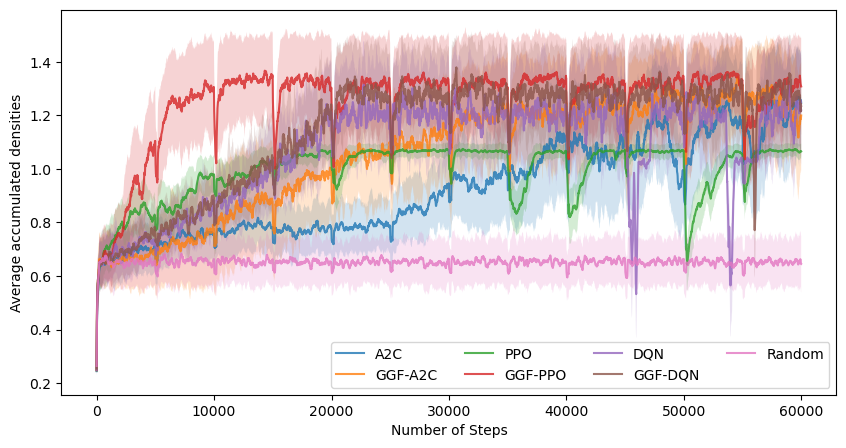

In [2]:
def plot_accumulated_density(df, algs_list):
    plt.figure(figsize=(10, 5))
    for alg in algs_list:
        alg_df = df[df['Algorithm']==alg]
        group_df = alg_df.groupby(['step']).first().reset_index()[['step']]
        group_df['Sum_mean'] = alg_df.groupby(['step'])['Sum'].mean().reset_index()['Sum']
        group_df['Sum_std'] = alg_df.groupby(['step'])['Sum'].std().reset_index()['Sum']
        # make the Sum_mean smoother and keep the same length
        ma_length = 20
        group_df['Sum_mean'] = group_df['Sum_mean'].rolling(ma_length, min_periods=1).mean()
        group_df['Sum_std'] = group_df['Sum_std'].rolling(ma_length, min_periods=1).mean()

        plt.plot(group_df['step'], group_df['Sum_mean'], label=alg, alpha = 0.8)
        plt.fill_between(group_df['step'], group_df['Sum_mean'] - group_df['Sum_std'], group_df['Sum_mean'] + group_df['Sum_std'], alpha=0.2)
    
    plt.xlabel('Number of Steps')
    plt.ylabel('Average accumulated densities')
    plt.legend(ncol = 4, loc = 'lower right')
    plt.savefig('figs/accumulated_density.pdf', bbox_inches= 'tight')
    plt.show()

result_df_filter = result_df[result_df['step'] <60000]
result_df_filter = result_df_filter[result_df_filter['step'] % 10 == 0]
plot_accumulated_density(result_df_filter, keys_list)

### Figure 3, GGF scores during testing

<Figure size 1000x500 with 0 Axes>

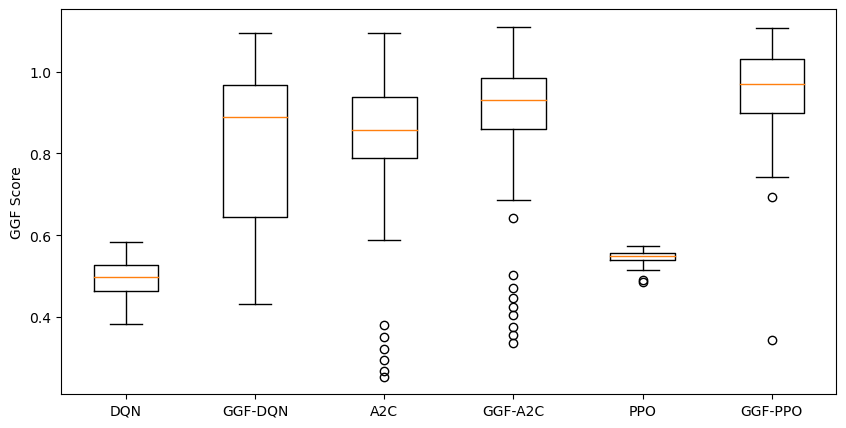

In [3]:
# boxplot with matplotlib
plt.figure(figsize=(10, 5))
# use data after 60000 steps, per 5000 steps and last 5 steps of each 5000 steps
final_result_df = result_df[result_df['step'] >= max(result_df['step']) - 10]
boxplot_data = []
keys_list_boxplot = ['DQN', 'GGF-DQN', 'A2C', 'GGF-A2C', 'PPO', 'GGF-PPO']
for key in keys_list_boxplot:
    boxplot_data.append(final_result_df[final_result_df['Algorithm'] == key]['GGF_Score'].to_numpy())
# boxplot with matplotlib
plt.figure(figsize=(10, 5))
plt.ylabel('GGF Score')
plt.boxplot(boxplot_data, labels=keys_list_boxplot)
plt.savefig('figs/ggf.pdf', bbox_inches='tight')
plt.show()

### Figure 4, Individual densities 

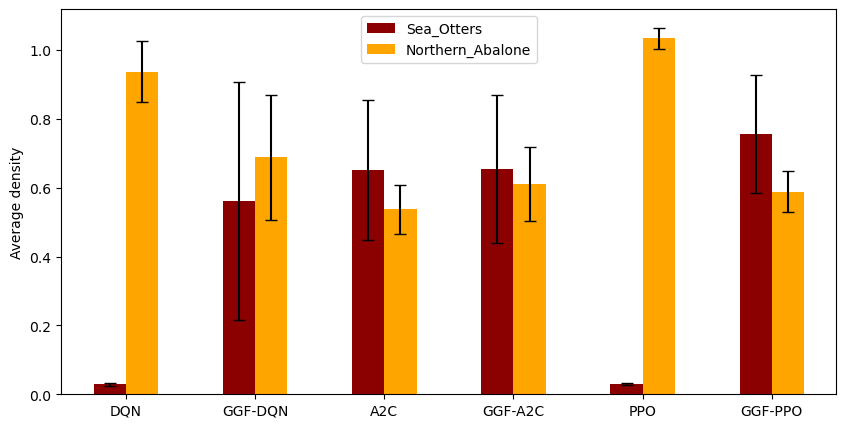

In [4]:
# barchart
# for each algorithm, compute average density and std, use dataframe.groupby
final_result_barchart = final_result_df.groupby(['Algorithm']).mean(numeric_only = True).reset_index()
final_result_barchart['Sea_Otters_std'] = final_result_df.groupby(['Algorithm']).std(numeric_only = True).reset_index()['Sea_Otters']
final_result_barchart['Northern_Abalone_std'] = final_result_df.groupby(['Algorithm']).std(numeric_only = True).reset_index()['Northern_Abalone']
# sort and filter by 'Algorithm' and keys_list_boxplot
final_result_barchart = final_result_barchart[final_result_barchart['Algorithm'].isin(keys_list_boxplot)]
# sort by the order of keys_list_boxplot
final_result_barchart = final_result_barchart.set_index('Algorithm').reindex(keys_list_boxplot).reset_index()
# plot with matplotlib
ax = plt.figure(figsize=(10, 5))
final_result_barchart.plot(
    x='Algorithm', 
    y=['Sea_Otters', 'Northern_Abalone'], 
    kind='bar',  
    capsize=4, 
    rot=0, 
    yerr=final_result_barchart[['Sea_Otters_std', 'Northern_Abalone_std']].values.T,
    color=['darkred', 'orange'],
    ax = ax.gca()
    )
plt.xlabel('')
plt.ylabel('Average density')
plt.legend(loc = 'best')
plt.savefig('figs/individual_density.pdf', bbox_inches=save_bbox)
plt.show()

#### Metrics: CV, Min, Max

/tmp/ipykernel_11247/3909141300.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fig5_df_x = fig5_df_x.melt('Algorithm').pivot('variable', 'Algorithm', 'value').reset_index().rename_axis(columns=None)


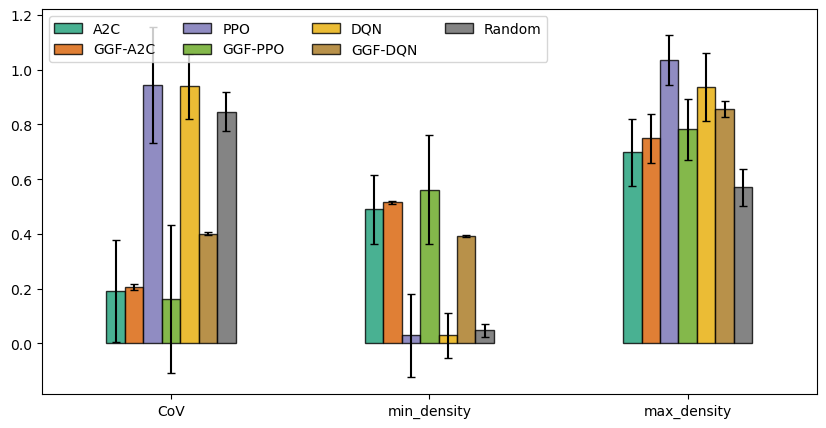

In [5]:
# figure 5
final_result_df_fig5 = final_result_df.copy()
# compute Coefficient of Variation
compute_cov = lambda x: np.std(x[['Sea_Otters','Northern_Abalone']]) / np.mean(x[['Sea_Otters','Northern_Abalone']])
# compute mean and std of Coefficient of Variation
final_result_df_fig5['CoV'] = final_result_df_fig5.apply(compute_cov, axis = 1)
# min density
final_result_df_fig5['min_density'] = final_result_df_fig5[['Sea_Otters','Northern_Abalone']].min(axis = 1)
# max density
final_result_df_fig5['max_density'] = final_result_df_fig5[['Sea_Otters','Northern_Abalone']].max(axis = 1)
# for each metric in ['CoV', 'min_density', 'max_density'], compute average value and std, use dataframe.groupby
final_result_df_fig5_barchart = final_result_df_fig5.groupby(['Algorithm']).mean(numeric_only = True).reset_index()
final_result_df_fig5_barchart['CoV_std'] = final_result_df_fig5.groupby(['Algorithm']).std(numeric_only = True).reset_index()['CoV']
final_result_df_fig5_barchart['min_density_std'] = final_result_df_fig5.groupby(['Algorithm']).std(numeric_only = True).reset_index()['min_density']
final_result_df_fig5_barchart['max_density_std'] = final_result_df_fig5.groupby(['Algorithm']).std(numeric_only = True).reset_index()['max_density']
fig5_df_x = final_result_df_fig5_barchart[['Algorithm', 'CoV', 'min_density', 'max_density']]
# sort by the order ['CoV', 'min_density', 'max_density']
fig5_df_x = fig5_df_x.melt('Algorithm').pivot('variable', 'Algorithm', 'value').reset_index().rename_axis(columns=None)
fig5_df_x = fig5_df_x.set_index('variable').reindex(['CoV', 'min_density', 'max_density']).reset_index()
# compute yerr
fig5_df_yerr = final_result_df_fig5_barchart[['CoV_std', 'min_density_std', 'max_density_std']].values
# plot with matplotlib
ax = plt.figure(figsize=(10, 5))
fig5_df_x.plot(
    x='variable', 
    y=keys_list, 
    kind='bar',  
    capsize=3, 
    rot=0, 
    yerr=fig5_df_yerr,
    colormap='Dark2',
    edgecolor = 'black',
    alpha = 0.8,
    ax = ax.gca()
    )
# delete xlabel
plt.xlabel('')
plt.legend(ncol = 4,loc = 'best')
plt.savefig('figs/cv_min_max.pdf', bbox_inches=save_bbox)
plt.show()

#### GGF score during training

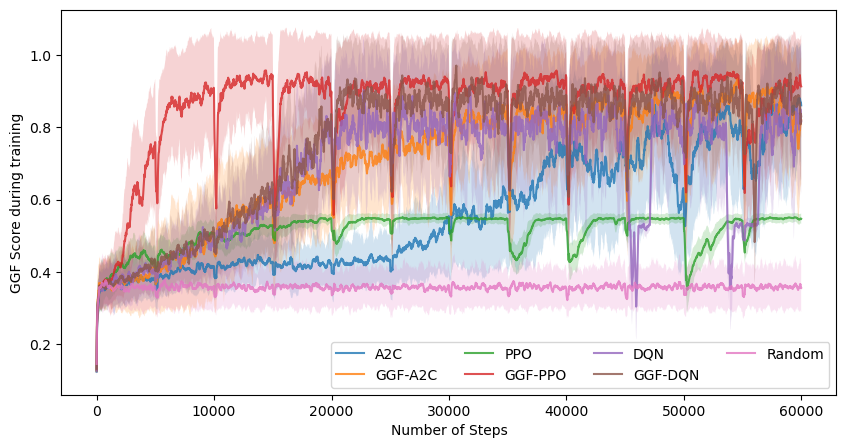

In [6]:
def plot_GGF_score(df, algs_list):
    plt.figure(figsize=(10, 5))
    for alg in algs_list:
        alg_df = df[df['Algorithm']==alg]
        group_df = alg_df.groupby(['step']).first().reset_index()[['step']]
        group_df['GGF_mean'] = alg_df.groupby(['step'])['GGF_Score'].mean().reset_index()['GGF_Score']
        group_df['GGF_std'] = alg_df.groupby(['step'])['GGF_Score'].std().reset_index()['GGF_Score']
        # make the Sum_mean smoother and keep the same length
        ma_length = 20
        group_df['GGF_mean'] = group_df['GGF_mean'].rolling(ma_length, min_periods=1).mean()
        group_df['GGF_std'] = group_df['GGF_std'].rolling(ma_length, min_periods=1).mean()

        plt.plot(group_df['step'], group_df['GGF_mean'], label=alg, alpha = 0.8)
        plt.fill_between(group_df['step'], group_df['GGF_mean'] - group_df['GGF_std'], group_df['GGF_mean'] + group_df['GGF_std'], alpha=0.2)
    
    plt.xlabel('Number of Steps')
    plt.ylabel('GGF Score during training')
    plt.legend(ncol = 4, loc = 'lower right')
    plt.savefig('figs/ggf_learning.pdf', bbox_inches= 'tight')
    plt.show()

plot_GGF_score(result_df_filter, keys_list)